## 0. Load packages

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

## 1. Load data

In [2]:
train_data = pd.read_csv("train.csv")

In [3]:
train_data.info

<bound method DataFrame.info of         id                                 document  label
0        1                영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐      0
1        2             히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...      1
2        3     괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~      1
3        4              아무래도 20년도지난작품이라 지금보기는너무유치하다      0
4        5  지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.      0
...    ...                                      ...    ...
4995  4996                 좋은 배우들로 3류영화를 찍은 안타까운 영화      0
4996  4997   진짜 드럽게 재미없다 에드워드 호퍼 그림에 배경 빼고는 볼게 아닌영화      0
4997  4998                가장 실망스러운 영화.. 지금까지 본영화중..      0
4998  4999          이런 평점 테러, 네이버에서 좀 막아야 하는 것 아닌가?      1
4999  5000      여주인공이 전작에서는 귀여웠는데, 여기선 완전 망했네, 실망이다      0

[5000 rows x 3 columns]>

In [4]:
train_data.head()

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0


## 2. EDA

In [5]:
# 결측치 없음
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [6]:
# 중복값 없음
train_data[train_data.duplicated()]

,id,document,label


<Axes: >

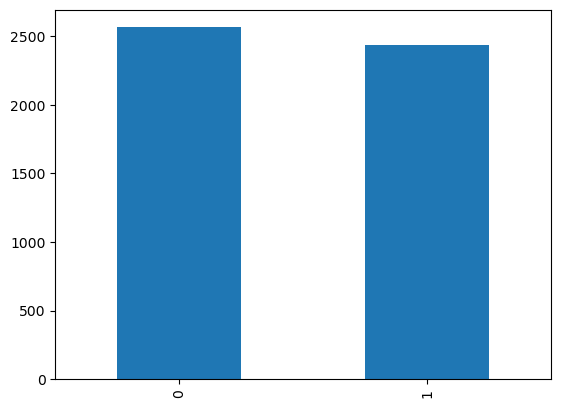

In [7]:
# label 값의 분포
train_data["label"].value_counts().plot(kind = "bar")

In [8]:
train_data.groupby("label").size().reset_index(name = "n")

,label,n
0,0,2564
1,1,2436


- train_data의 특수문자 제거
- 한글 자음과 모음의 범위
    - ㄱ ~ ㅎ: 3131 ~ 314E
    - ㅏ ~ ㅣ: 314F ~ 3163

In [9]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex = True)
train_data[:5]

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯,1
2,3,괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요,1
3,4,아무래도 년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯 이 영화역시 일본에 대한 미화는 여전하다,0


원래 한글이 없는 리뷰였다면 아무런 값도 없는 빈 값이 되었을 것이다. 빈 값을 가진 행이 있다면 Null값으로 변경하고, Null값이 존재하는지 확인해 보자.

In [10]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex = True) # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id           0
document    10
label        0
dtype: int64


Null 값이 10개 새로 생겼음을 알 수 있다.

In [11]:
train_data.loc[train_data.document.isnull()]

,id,document,label
159,160,NaN,1
659,660,NaN,1
721,722,NaN,1
1921,1922,NaN,1
2466,2467,NaN,1
2717,2718,NaN,1
3693,3694,NaN,1
4126,4127,NaN,1
4147,4148,NaN,1
4765,4766,NaN,1


Null 샘플들은 레이블이 긍정일 수도 있고, 부정일 수도 있다. 아무런 의미가 없는 데이터이므로 제거.

In [12]:
train_data = train_data.dropna(how = "any")

In [13]:
# Null 값 10개가 제거됨.
len(train_data)

4990

In [14]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(train_data[["id", "document"]], train_data[["label"]], test_size=0.2, random_state=42)

In [15]:
train_X

,id,document
1454,1455,이게 영화인지 쓰레기인지 암튼 재미없다
3767,3768,이렇게 지루한 공포영화는 처음인게 호러
4413,4414,감독의 과한 욕심이 초래한 참극 똥을 잘 빚어서 예쁘게 데코한 느낌
882,883,곽경택 감독님 지휘 하에 연기하고 싶은 날입니다정말 대단하신 분이다
2566,2567,정말 감동적으로 본 영화에요
...,...,...
4435,4436,이게 대체 왜 점대인지 이해할 수 없음
467,468,견자단과 성룡의 대결씬과 이쁜 여자들만 볼만 나머진 기대 하지 말것
3098,3099,재미도 없고내용도 뻔하고핵심이 되어야 할 긴장감도 없다
3779,3780,정말 심하다 각본도 뒤죽박죽 그들은 알지만 우리는 모르는 일만


In [16]:
test_X

,id,document
4736,4737,한국 드라마중 최고의 시청률 시청률을 봐도 알 수 있듯이 그당시 최고였다
2320,2321,홍콩명배우 모두출연함 ㅎㅎ 성룡이연걸유덕화홍금보오경 등등 굿
3675,3676,야밤에 완전 깔깔대고 웃었다 정신없고 재밌음 ㅋㅋ
1215,1216,잔인 스토리탄탄하고 작품성있고 몰입성도 좋지만 뭐랄까 안타깝달까
3038,3039,아좋다 이걸 이제 보다니
...,...,...
3533,3534,너무너무 잼나요 역시 꿀잼
4553,4554,송승헌엄정아연기잘하네요잼났습니다웃기겅
4038,4039,감히 이 영화가 반열에 오른다고 있을 수 없다 그래서 점
4916,4917,오싹한 비쥬얼에 비해 아무런 영감을 주지못하는 도식적인 플롯


## 3. Tokenization

In [17]:
from konlpy.tag import Komoran
komoran = Komoran()

In [18]:
# label = 0인 리뷰 토큰화
negative = []
for sentence in tqdm(train_data.query("label == 0")["document"]):
    # Komoran 형태소 분석기 사용
    tokenized_sentence = komoran.morphs(sentence)
    
    all_sentence = [word for word in tokenized_sentence]
    negative.append(all_sentence)

100%|████████████████████████████████████████████████████████████████████████████| 2564/2564 [00:02<00:00, 1194.30it/s]


In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(negative)
print(tokenizer.word_index)

{'하': 1, '이': 2, 'ㄴ': 3, '는': 4, '다': 5, '영화': 6, '보': 7, '고': 8, '도': 9, '가': 10, '에': 11, '게': 12, '았': 13, '은': 14, '없': 15, 'ㄹ': 16, '을': 17, '의': 18, '지': 19, '었': 20, '아': 21, '어': 22, '나': 23, '를': 24, 'ㅁ': 25, '만': 26, '들': 27, '너무': 28, '아깝': 29, '네': 30, '점': 31, '는데': 32, '기': 33, '되': 34, '음': 35, '주': 36, '지루': 37, '것': 38, '뭐': 39, '아니': 40, '왜': 41, '재미없': 42, '내': 43, '진짜': 44, '만들': 45, '안': 46, '로': 47, '있': 48, '말': 49, '평점': 50, 'ㄴ다': 51, '이런': 52, '나오': 53, '아서': 54, '정말': 55, '거': 56, '시간': 57, '으로': 58, '스토리': 59, '겠': 60, '내용': 61, '않': 62, '재미': 63, '면': 64, '냐': 65, '연기': 66, '같': 67, '최악': 68, '적': 69, '그냥': 70, '수': 71, '보다': 72, '에서': 73, '지만': 74, '좋': 75, '감독': 76, '배우': 77, '좀': 78, '이렇': 79, '듯': 80, '이것': 81, '오': 82, '쓰레기': 83, '돈': 84, '알': 85, '과': 86, '그': 87, '못하': 88, '어요': 89, '까지': 90, '시': 91, '네요': 92, '이건': 93, '라': 94, '건': 95, '어서': 96, '별로': 97, '끝': 98, 'ㄴ가': 99, '참': 100, '더': 101, '재': 102, '개': 103, '모르': 104, '던': 105, 'ㅡㅡ': 106, '싶'

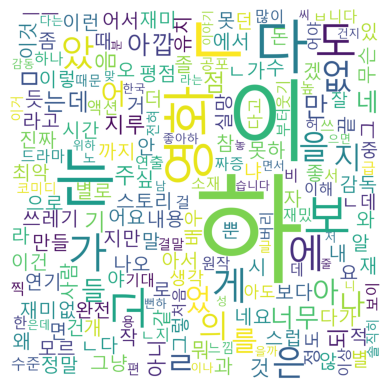

In [20]:
# negative wordcloud

c = Counter(tokenizer.word_index)

# 최대 등장 횟수를 찾습니다.
max_frequency = max(c.values())

# WordCloud 객체 생성
wc = WordCloud(font_path='malgun', width=800, height=800, scale=2.0, max_font_size=250, background_color='white')

# 단어별 크기를 등장 횟수의 역수로 설정하여 WordCloud를 생성
# 등장 횟수가 많은 단어일수록 크기가 작게 표시됩니다.
wordcloud_data = {word: max_frequency / freq for word, freq in c.items()}

# WordCloud를 생성
gen = wc.generate_from_frequencies(wordcloud_data)

# WordCloud를 시각화
plt.figure()
plt.imshow(gen)
plt.axis("off")  # 축 제거 (optional)
plt.show()

In [21]:
# label = 1인 리뷰 토큰화
positive = []
for sentence in tqdm(train_data.query("label == 1")["document"]):
    # Komoran 형태소 분석기 사용
    tokenized_sentence = komoran.morphs(sentence)
    
    all_sentence = [word for word in tokenized_sentence]
    positive.append(all_sentence)

100%|████████████████████████████████████████████████████████████████████████████| 2426/2426 [00:01<00:00, 1756.80it/s]


In [22]:
tokenizer.fit_on_texts(positive)
print(tokenizer.word_index)

{'이': 1, '하': 2, 'ㄴ': 3, '는': 4, '영화': 5, '다': 6, '보': 7, '고': 8, '도': 9, '의': 10, '에': 11, '가': 12, '았': 13, '게': 14, '은': 15, 'ㄹ': 16, '었': 17, '을': 18, '지': 19, '어': 20, '아': 21, '없': 22, 'ㅁ': 23, '들': 24, '를': 25, '나': 26, '너무': 27, '있': 28, '좋': 29, '되': 30, '정말': 31, '만': 32, '는데': 33, '재밌': 34, '음': 35, '주': 36, '진짜': 37, '적': 38, '것': 39, '내': 40, '네': 41, '최고': 42, '어요': 43, '기': 44, '점': 45, '네요': 46, '말': 47, 'ㄴ다': 48, '연기': 49, '만들': 50, '지만': 51, '왜': 52, '으로': 53, '로': 54, '않': 55, '안': 56, '수': 57, '아서': 58, '평점': 59, '같': 60, '과': 61, '나오': 62, '이런': 63, '아깝': 64, '에서': 65, '아니': 66, 'ㅂ니다': 67, '뭐': 68, '지루': 69, '던': 70, '잘': 71, '거': 72, '감동': 73, '면': 74, '배우': 75, '재': 76, '재미': 77, '재미없': 78, '겠': 79, '싶': 80, '재미있': 81, '때': 82, '보다': 83, '시': 84, '그': 85, '요': 86, '중': 87, '시간': 88, '스토리': 89, '드라마': 90, '내용': 91, '습니다': 92, '오': 93, '더': 94, '이렇': 95, '와': 96, '감독': 97, '듯': 98, '생각': 99, '알': 100, '아도': 101, '까지': 102, '그냥': 103, '이것': 104, '사람': 105, '냐': 106,

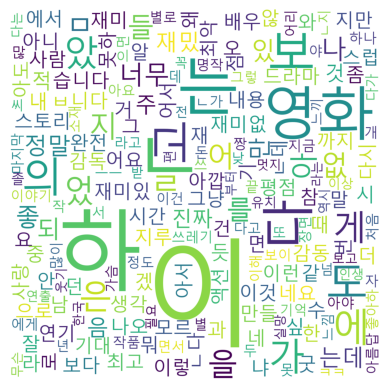

In [23]:
# positive wordcloud

c = Counter(tokenizer.word_index)

# 최대 등장 횟수를 찾습니다.
max_frequency = max(c.values())

# WordCloud 객체 생성
wc = WordCloud(font_path='malgun', width=800, height=800, scale=2.0, max_font_size=250, background_color='white')

# 단어별 크기를 등장 횟수의 역수로 설정하여 WordCloud를 생성
# 등장 횟수가 많은 단어일수록 크기가 작게 표시됩니다.
wordcloud_data = {word: max_frequency / freq for word, freq in c.items()}

# WordCloud를 생성
gen = wc.generate_from_frequencies(wordcloud_data)

# WordCloud를 시각화
plt.figure()
plt.imshow(gen)
plt.axis("off")  # 축 제거 (optional)
plt.show()

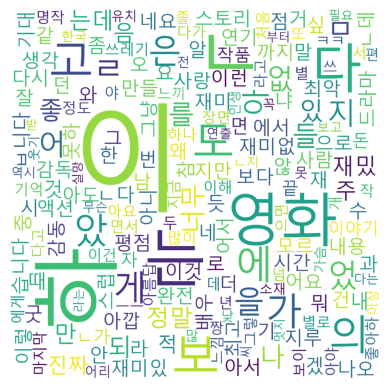

In [24]:
# 불용어 제거 전 전체 단어의 word cloud

c = Counter(tokenizer.word_index)

# 최대 등장 횟수를 찾습니다.
max_frequency = max(c.values())

# WordCloud 객체 생성
wc = WordCloud(font_path='malgun', width=800, height=800, scale=2.0, max_font_size=250, background_color='white')

# 단어별 크기를 등장 횟수의 역수로 설정하여 WordCloud를 생성
# 등장 횟수가 많은 단어일수록 크기가 작게 표시됩니다.
wordcloud_data = {word: max_frequency / freq for word, freq in c.items()}

# WordCloud를 생성
gen = wc.generate_from_frequencies(wordcloud_data)

# WordCloud를 시각화
plt.figure()
plt.imshow(gen)
plt.axis("off")  # 축 제거 (optional)
plt.show()

In [25]:
# 불용어 설정
stopwords = ['영화', '이', '의', '가', '에', '도', '을', '는', '를', '은', '한', '다', '만',  '로', '과',  '으로', '것', '에서', '게', '인', '이다', '요', '까지', '하는', '고', '하고', '지',  '입니다',  '있다','하다','되다','다', '하', '고', '는데',  '었', '했', '으로', '겠', '면',  '았', '에서', '네요', '알', '해',  '습니다', '어요', '때', '과',  '하다', 'ㄹ',  '어', '아', 'ㅂ니다', '걍', '과', '도', '으로', '자', '한', '하다', '하', 'ㄴ', 'ㅁ',  '주', '적','기',  '어요', 'ㄴ다', '아서', '로', '수',  '던',  '그',  '시', '냐', '어서', '아도', '라', 'ㄴ데', '스럽', 'ㄴ가']

In [26]:
# train data 토큰화
X_train = []
for sentence in tqdm(train_X["document"]):
    # Komoran 형태소 분석기 사용
    tokenized_sentence = komoran.morphs(sentence)
    
    # 불용어 제거
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)

100%|████████████████████████████████████████████████████████████████████████████| 3992/3992 [00:02<00:00, 1539.41it/s]


In [27]:
X_train[:5]

[['ㄴ지', '쓰레기', '인지', '암', '트', '재미없'],
 ['이렇', '지루', '공포', '처음', '호러'],
 ['감독', '욕심', '초래', '참극', '똥', '잘', '빚', '예쁘', '데코', '느낌'],
 ['곽경택', '감독', '님', '지휘', '연기', '싶', '날', '정말', '대단', '분'],
 ['정말', '감동', '보']]

In [28]:
# test data 토큰화
X_test = []
for sentence in tqdm(test_X["document"]):
    # Komoran 형태소 분석기 사용
    tokenized_sentence = komoran.morphs(sentence)
    
    # 불용어 제거
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(stopwords_removed_sentence)

100%|██████████████████████████████████████████████████████████████████████████████| 998/998 [00:00<00:00, 1517.72it/s]


In [29]:
X_test[:5]

[['한국', '드라마', '중', '최고', '시청률', '시청률', '보', '있', '듯이', '당시', '최고'],
 ['홍콩',
  '명',
  '배우',
  '모두',
  '출연',
  'ㅎㅎ',
  '성룡',
  '이연걸',
  '유덕화',
  '홍금보',
  '오경',
  '등등',
  '굿'],
 ['야밤', '완전', '깔깔대', '웃', '정신없', '재밌', '음', 'ㅋㅋ'],
 ['잔인',
  '스토리',
  '탄탄',
  '작품',
  '성',
  '있',
  '몰입',
  '성도',
  '좋',
  '지만',
  '뭐',
  '랄까',
  '안타깝',
  '다고',
  'ㄹ까'],
 ['좋', '이거', '이제', '보', '다니']]

## 4. Integer Encoding

In [30]:
# 훈련 데이터의 단어집합 만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [31]:
# 단어 집합의 생성과 동시에 각 단어에 고유한 정수 부여
print(tokenizer.word_index)

{'보': 1, '없': 2, '들': 3, '나': 4, '있': 5, '너무': 6, '좋': 7, '정말': 8, '되': 9, '음': 10, '재밌': 11, '진짜': 12, '내': 13, '최고': 14, '네': 15, '점': 16, '연기': 17, '만들': 18, '지만': 19, '말': 20, '왜': 21, '않': 22, '안': 23, '평점': 24, '같': 25, '아니': 26, '나오': 27, '이런': 28, '아깝': 29, '잘': 30, '거': 31, '감동': 32, '지루': 33, '재미없': 34, '뭐': 35, '배우': 36, '재': 37, '재미있': 38, '싶': 39, '재미': 40, '스토리': 41, '보다': 42, '중': 43, '내용': 44, '이렇': 45, '드라마': 46, '오': 47, '와': 48, '더': 49, '시간': 50, '감독': 51, '사람': 52, '그냥': 53, '듯': 54, '생각': 55, '이것': 56, '번': 57, '완전': 58, '다시': 59, '최악': 60, '액션': 61, '기대': 62, '좀': 63, '못하': 64, '모르': 65, '작품': 66, '남': 67, '사랑': 68, '참': 69, '굿': 70, '건': 71, '돈': 72, '이야기': 73, '쓰레기': 74, '면서': 75, '별로': 76, '이건': 77, '끝': 78, '개': 79, '좋아하': 80, '아요': 81, '작': 82, '마지막': 83, '라고': 84, '이해': 85, '기억': 86, '넘': 87, '보이': 88, '두': 89, '서': 90, '다가': 91, '느끼': 92, '아름답': 93, '졸': 94, '짱': 95, '소재': 96, 'ㅋㅋ': 97, '또': 98, '야': 99, '하나': 100, '쓰': 101, '많이': 102, '그렇': 103, '에게': 104

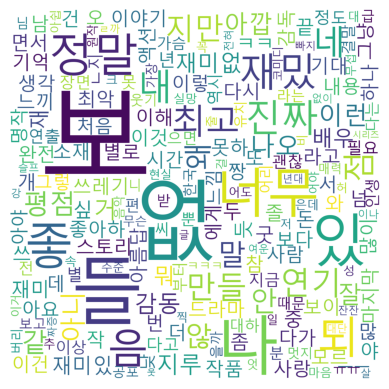

In [32]:
# 불용어 제거 후 word cloud

c = Counter(tokenizer.word_index)

# 최대 등장 횟수를 찾습니다.
max_frequency = max(c.values())

# WordCloud 객체 생성
wc = WordCloud(font_path='malgun', width=800, height=800, scale=2.0, max_font_size=250, background_color='white')

# 단어별 크기를 등장 횟수의 역수로 설정하여 WordCloud를 생성
# 등장 횟수가 많은 단어일수록 크기가 작게 표시됩니다.
wordcloud_data = {word: max_frequency / freq for word, freq in c.items()}

# WordCloud를 생성
gen = wc.generate_from_frequencies(wordcloud_data)

# WordCloud를 시각화
plt.figure()
plt.imshow(gen)
plt.axis("off")  # 축 제거 (optional)
plt.show()

높은 정수가 부여된 단어일수록 등장 빈도수가 낮다. 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 차지하는 비중을 확인하고 자연어 처리에서 배제하고자 한다.

In [33]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 5718
등장 빈도가 2번 이하인 희귀 단어의 수: 4115
단어 집합에서 희귀 단어의 비율: 71.96572228051767
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 16.171357344354785


In [34]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1604


In [35]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [36]:
X_train[:5]

[[116, 74, 493, 534, 749, 34],
 [45, 33, 150, 108, 1000],
 [51, 854, 30, 281, 109],
 [51, 151, 17, 39, 588, 8, 192, 138],
 [8, 32, 1]]

In [37]:
X_test[:5]

[[141, 46, 43, 14, 819, 819, 1, 5, 1186, 282, 14],
 [1015, 332, 36, 234, 428, 227, 647, 1159, 70],
 [58, 200, 11, 10, 97],
 [582, 41, 1562, 66, 170, 5, 244, 7, 19, 35, 706, 112, 185],
 [7, 182, 222, 1, 209]]

## 5. Remove empty samples

In [38]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [39]:
len(drop_train)

33

In [40]:
drop_train

[17,
 29,
 303,
 375,
 436,
 543,
 613,
 800,
 845,
 965,
 1029,
 1283,
 1293,
 1455,
 1484,
 1673,
 1847,
 1879,
 1888,
 2008,
 2029,
 2054,
 2435,
 2756,
 2813,
 2908,
 3019,
 3298,
 3354,
 3418,
 3419,
 3846,
 3939]

In [41]:
X_train = [X_train[i] for i in range(len(X_train)) if i not in drop_train]
len(X_train)

3959

In [42]:
y_train = train_y.drop(train_y.index[drop_train])
y_train

,label
1454,0
3767,0
4413,0
882,1
2566,1
...,...
4435,0
467,0
3098,0
3779,0


In [43]:
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [44]:
len(drop_test)

12

## 6. padding

리뷰의 최대 길이 : 26
리뷰의 평균 길이 : 6.4551654458196515


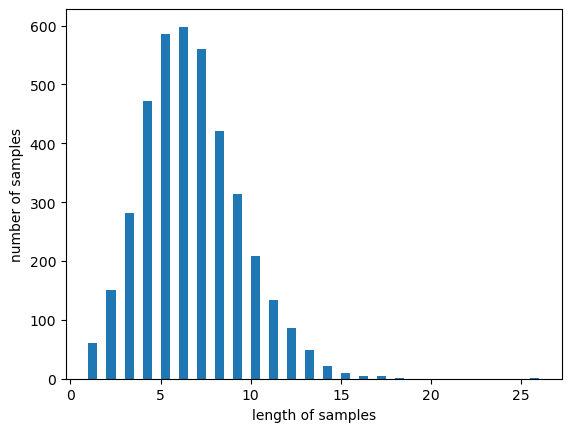

In [45]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [46]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [47]:
max_len = 15
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 15 이하인 샘플의 비율: 99.72215205860066


전체 훈련 데이터 중 약 98.9%의 리뷰가 20 이하의 길이를 가지므로 모든 샘플의 길이를 20으로 조정

In [48]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [49]:
X_train

array([[   0,    0,    0, ...,  534,  749,   34],
       [   0,    0,    0, ...,  150,  108, 1000],
       [   0,    0,    0, ...,   30,  281,  109],
       ...,
       [   0,    0,    0, ...,  183,  275,    2],
       [   0,    0,    0, ...,  254,   65,  164],
       [   0,    0,    0, ...,  221,  167,  260]])

In [50]:
X_test

array([[   0,    0,    0, ..., 1186,  282,   14],
       [   0,    0,    0, ...,  647, 1159,   70],
       [   0,    0,    0, ...,   11,   10,   97],
       ...,
       [   0,    0,    0, ...,    2,  497,   16],
       [   0,    0,    0, ..., 1122,   64, 1592],
       [   0,    0,    0, ...,  697,   42,   30]])

In [51]:
y_train = np.array(y_train)
y_train

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [52]:
y_test = np.array(test_y)
print(y_test)

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]


## 7. Classify review

In [53]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Conv1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

### 1) RNN(Recurrent Neural Network)

In [ ]:
max_length = 15
embedding_dim = 128

model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_rnn.add(SimpleRNN(units=128))  # RNN layer
model_rnn.add(Dense(units=1, activation='sigmoid'))  # Output layer

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_rnn.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history_rnn = model_rnn.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[es, mc], epochs=15, batch_size=128)

# 훈련 중 손실과 검증 손실 추출
train_loss = history_rnn.history['loss']
val_loss = history_rnn.history['val_loss']

# 에폭 수 만큼의 리스트 생성 (1부터 시작)
epochs = range(1, len(train_loss) + 1)

# 손실 그래프 생성
plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_rnn.save('best_model_rnn.h5')
loaded_model = load_model('best_model_rnn.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

### 2) CNN(Convolutional neural network)

In [54]:
max_length = 15
embedding_dim = 128

model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(MaxPooling1D(5))
model_cnn.add(Flatten())
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/15
31/31 [==============================] - 2s 27ms/step - loss: 0.6797 - accuracy: 0.5830 - val_loss: 0.6493 - val_accuracy: 0.7134
Epoch 2/15
31/31 [==============================] - 0s 13ms/step - loss: 0.5323 - accuracy: 0.8156 - val_loss: 0.4653 - val_accuracy: 0.7906
Epoch 3/15
31/31 [==============================] - 0s 11ms/step - loss: 0.3328 - accuracy: 0.8575 - val_loss: 0.4359 - val_accuracy: 0.7976
Epoch 4/15
31/31 [==============================] - 0s 12ms/step - loss: 0.2407 - accuracy: 0.8987 - val_loss: 0.4710 - val_accuracy: 0.7976
Epoch 5/15
31/31 [==============================] - 0s 12ms/step - loss: 0.1866 - accuracy: 0.9252 - val_loss: 0.5168 - val_accuracy: 0.7936
Epoch 6/15
31/31 [==============================] - 0s 13ms/step - loss: 0.1504 - accuracy: 0.9411 - val_loss: 0.5730 - val_accuracy: 0.7886
Epoch 7/15
31/31 [==============================] - 0s 10ms/step - loss: 0.1213 - accuracy: 0.9550 - val_loss: 0.6296 - val_accuracy: 0.7896
Epoch 7: earl

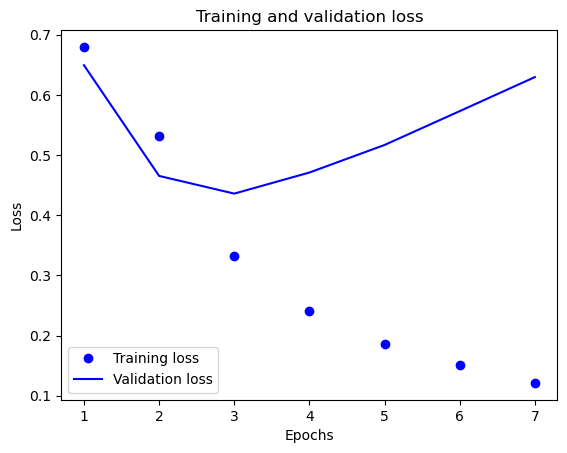

In [55]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history_cnn = model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[es, mc], epochs=15, batch_size=128)

# 훈련 중 손실과 검증 손실 추출
train_loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

# 에폭 수 만큼의 리스트 생성 (1부터 시작)
epochs = range(1, len(train_loss) + 1)

# 손실 그래프 생성
plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
model_cnn.save('best_model_cnn.h5')
loaded_model = load_model('best_model_cnn.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

32/32 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.7896

 테스트 정확도: 0.7896


### 3) LSTM

Epoch 1/15
48/50 [===========================>..] - ETA: 0s - loss: 0.6716 - acc: 0.6240
Epoch 1: val_acc improved from -inf to 0.74621, saving model to best_model_lstm.h5
50/50 [==============================] - 6s 40ms/step - loss: 0.6696 - acc: 0.6274 - val_loss: 0.5947 - val_acc: 0.7462
Epoch 2/15
47/50 [===========================>..] - ETA: 0s - loss: 0.4738 - acc: 0.8019
Epoch 2: val_acc improved from 0.74621 to 0.83712, saving model to best_model_lstm.h5
50/50 [==============================] - 1s 22ms/step - loss: 0.4692 - acc: 0.8049 - val_loss: 0.3948 - val_acc: 0.8371
Epoch 3/15
50/50 [==============================] - ETA: 0s - loss: 0.3183 - acc: 0.8677
Epoch 3: val_acc improved from 0.83712 to 0.84848, saving model to best_model_lstm.h5
50/50 [==============================] - 1s 21ms/step - loss: 0.3183 - acc: 0.8677 - val_loss: 0.3472 - val_acc: 0.8485
Epoch 4/15
47/50 [===========================>..] - ETA: 0s - loss: 0.2504 - acc: 0.8986
Epoch 4: val_acc did not impr

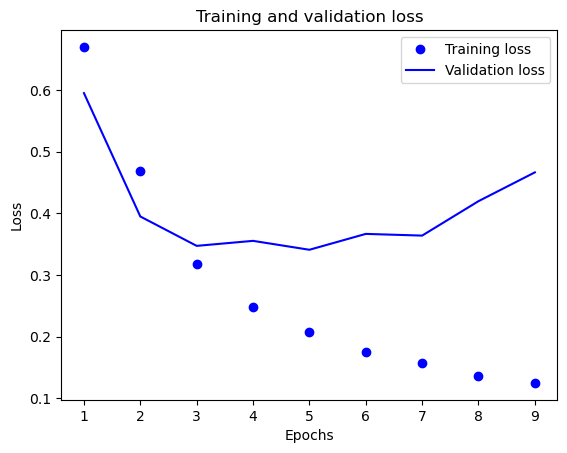

In [68]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

# history 객체에서 훈련과 검증 손실 추출
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 에폭 수 만큼의 리스트 생성 (1부터 시작)
epochs = range(1, len(train_loss) + 1)

# 손실 그래프 생성
plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [69]:
loaded_model = load_model('best_model_lstm.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

32/32 [==============================] - 1s 5ms/step - loss: 0.3984 - acc: 0.8327

 테스트 정확도: 0.8327


### 4) XGBoost

In [81]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# XGBoost 모델 학습 및 평가
def train_and_evaluate_xgboost(X_train, y_train, X_val, y_val):
    # XGBoost 데이터셋 생성
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # XGBoost 모델 파라미터 설정 (이 예시에서는 간단하게 설정)
    params = {
        'max_depth': 6,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.03
    }

    # 모델 훈련
    model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dval, 'validation')], early_stopping_rounds=10, verbose_eval=True)

    return model

# XGBoost 모델 학습
xgboost_model = train_and_evaluate_xgboost(X_train, y_train, X_test, y_test)

# 테스트 데이터 예측
dtest = xgb.DMatrix(X_test)
y_pred = xgboost_model.predict(dtest, iteration_range=(0, xgboost_model.best_iteration))

# 예측값을 이진 클래스로 변환
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred_binary)
print('Test Accuracy:', accuracy)

[0]	validation-logloss:0.69061
[1]	validation-logloss:0.68837
[2]	validation-logloss:0.68620
[3]	validation-logloss:0.68413
[4]	validation-logloss:0.68235
[5]	validation-logloss:0.68054
[6]	validation-logloss:0.67900
[7]	validation-logloss:0.67760
[8]	validation-logloss:0.67565
[9]	validation-logloss:0.67436
[10]	validation-logloss:0.67256
[11]	validation-logloss:0.67107
[12]	validation-logloss:0.66964
[13]	validation-logloss:0.66848
[14]	validation-logloss:0.66737
[15]	validation-logloss:0.66618
[16]	validation-logloss:0.66511
[17]	validation-logloss:0.66350
[18]	validation-logloss:0.66263
[19]	validation-logloss:0.66108
[20]	validation-logloss:0.66033
[21]	validation-logloss:0.65904
[22]	validation-logloss:0.65833
[23]	validation-logloss:0.65769
[24]	validation-logloss:0.65597
[25]	validation-logloss:0.65525
[26]	validation-logloss:0.65474
[27]	validation-logloss:0.65281
[28]	validation-logloss:0.65231
[29]	validation-logloss:0.65172
[30]	validation-logloss:0.65034
[31]	validation-lo

### 5) RandomForest

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 랜덤 포레스트 모델 학습 및 평가
def train_and_evaluate_random_forest(X_train, y_train, X_test, y_test):
    # 랜덤 포레스트 모델 초기화
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # 모델 훈련
    y_train = y_train.ravel()
    rf_model.fit(X_train, y_train)

    # 검증 데이터로 예측
    y_test_pred = rf_model.predict(X_test)

    # 정확도 평가
    test_accuracy = accuracy_score(y_test, y_test_pred)

    return rf_model

# 랜덤 포레스트 모델 학습
random_forest_model = train_and_evaluate_random_forest(X_train, y_train, X_test, y_test)

# 테스트 데이터로 예측
y_test_pred = random_forest_model.predict(X_test)

# 정확도 평가
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test Accuracy:', test_accuracy)

Test Accuracy: 0.6052104208416834


## 8. Predict review

In [70]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = komoran.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    return 1
  else:
    return 0

  '''if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))'''
    

In [71]:
sentiment_predict('그저 그런 영화')

1/1 [==============================] - 0s 427ms/step


0

In [72]:
test_data = pd.read_csv("test.csv")
test_data

,id,document
0,1,시간 때우기 좋은 영화 지루함
1,2,훈훈한 정이 느껴지는 영화! 가족끼리 드라마 보듯이 보면 딱~!
2,3,Childhood fantasy
3,4,멋있는 영화입니다. 잊을 수 없는!
4,5,너무 감동적이네요 펑펑 울었습니다
...,...,...
4995,4996,연계도 제대로 안되고 뭔가 부족한느낌이들고 찝찝한영화
4996,4997,내생에 최악의 영화중 하나 졸려서 미칠뻔....
4997,4998,지금까지 나온 드라마 중 최고였습니다. 100점 만점!
4998,4999,영화값으로 엄청난 공연을 보았다 - 이게 웬 횡재 ..


In [73]:
submission = []
for i in test_data['document'] :
    if re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", i).isspace() == False :
        if sentiment_predict(i) > 0.5 :
            submission.append(1)
        else :
            submission.append(0)
    else :
        submission.append("Null")

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 42ms/step


In [74]:
submission = pd.DataFrame(submission)
submission.columns = ["label"]
submission

,label
0,0
1,1
2,Null
3,1
4,1
...,...
4995,0
4996,0
4997,1
4998,1


In [75]:
submission.query("label == 'Null'")

,label
2,Null
458,Null
662,Null
756,Null
1023,Null
1313,Null
1325,Null
1386,Null
1392,Null
2294,Null


In [76]:
test_data.query("id == 663")

,id,document
662,663,LIFE + DOG = GREAT


In [77]:
# 영어 리뷰를 추출해보니 대부분 긍정적인 리뷰임을 확인
test_data[test_data['document'].str.match(r'^[^\u3131-\u3163\uac00-\ud7a3]+$')]

,id,document
2,3,Childhood fantasy
458,459,"""Amazing discovery!"""
662,663,LIFE + DOG = GREAT
756,757,It was very good!!!
1023,1024,You saw what you wanted to see.
1313,1314,thank you! very good job ^^
1325,1326,It was a nice super duper!!!!
1386,1387,Best animation ever
1392,1393,Brilliant! This is a must-see film
2294,2295,What a great drama!!!


In [78]:
# 영어 리뷰는 1로 대체
submission.loc[submission["label"] == "Null", "label"] = 1
submission.index += 1
submission

,label
1,0
2,1
3,1
4,1
5,1
...,...
4996,0
4997,0
4998,1
4999,1


In [79]:
submission.query("label == 'Null'")

,label


In [80]:
submission.to_csv("C:/Users/sol91/baf/MovieReview/submission_lstm.csv")

#### - XGBoost submission

In [82]:
test_data = pd.read_csv("test.csv")
test_data

,id,document
0,1,시간 때우기 좋은 영화 지루함
1,2,훈훈한 정이 느껴지는 영화! 가족끼리 드라마 보듯이 보면 딱~!
2,3,Childhood fantasy
3,4,멋있는 영화입니다. 잊을 수 없는!
4,5,너무 감동적이네요 펑펑 울었습니다
...,...,...
4995,4996,연계도 제대로 안되고 뭔가 부족한느낌이들고 찝찝한영화
4996,4997,내생에 최악의 영화중 하나 졸려서 미칠뻔....
4997,4998,지금까지 나온 드라마 중 최고였습니다. 100점 만점!
4998,4999,영화값으로 엄청난 공연을 보았다 - 이게 웬 횡재 ..


In [83]:
import xgboost as xgb
def sentiment_predict(new_sentence):
    encoded = tokenizer.texts_to_sequences([new_sentence])  # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen=max_len)  # 패딩
    dtest_new = xgb.DMatrix(pad_new)  # DMatrix 객체로 변환
    score = float(xgboost_model.predict(dtest_new))  # 예측
    if score > 0.5:
        return 1
    else:
        return 0

In [84]:
submission = []
for i in test_data['document']:
    if re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", i).isspace() == False:
        if sentiment_predict(i) > 0.5:
            submission.append(1)
        else:
            submission.append(0)
    else :
        submission.append(1)

In [85]:
submission

[0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [86]:
len(submission)

5000

In [87]:
submission = pd.DataFrame(submission)
submission.columns = ["label"]
submission

,label
0,0
1,0
2,1
3,1
4,1
...,...
4995,1
4996,1
4997,0
4998,1


In [88]:
submission.to_csv("C:/Users/sol91/baf/MovieReview/submission_xgb.csv")

#### - RandomForest submission

In [90]:
test_data = pd.read_csv("test.csv")
test_data

,id,document
0,1,시간 때우기 좋은 영화 지루함
1,2,훈훈한 정이 느껴지는 영화! 가족끼리 드라마 보듯이 보면 딱~!
2,3,Childhood fantasy
3,4,멋있는 영화입니다. 잊을 수 없는!
4,5,너무 감동적이네요 펑펑 울었습니다
...,...,...
4995,4996,연계도 제대로 안되고 뭔가 부족한느낌이들고 찝찝한영화
4996,4997,내생에 최악의 영화중 하나 졸려서 미칠뻔....
4997,4998,지금까지 나온 드라마 중 최고였습니다. 100점 만점!
4998,4999,영화값으로 엄청난 공연을 보았다 - 이게 웬 횡재 ..


In [91]:
def sentiment_predict(new_sentence):
    encoded = tokenizer.texts_to_sequences([new_sentence])  # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen=max_len)  # 패딩
    return pad_new

In [92]:
submission = []
for i in test_data['document']:
    if re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", i).isspace() == False:
        pad_new = sentiment_predict(i)
        score = random_forest_model.predict(pad_new)  # 예측
        if score > 0.5:
            submission.append(1)
        else:
            submission.append(0)
    else :
        submission.append(1)

In [93]:
submission

[0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,


In [94]:
len(submission)

5000

In [95]:
submission = pd.DataFrame(submission)
submission.columns = ["label"]
submission

,label
0,0
1,0
2,1
3,0
4,0
...,...
4995,1
4996,1
4997,0
4998,0


In [96]:
submission.to_csv("C:/Users/sol91/baf/MovieReview/submission_RF.csv")